### Including necessary libs:

In [311]:
import matplotlib.pyplot as plt
import numpy as np
import math
from numpy.linalg import inv

Importing data:

In [312]:
X=np.array([(4,1940),(9,2960),(9,4630),(78,1528),(90,2040),(50,3700),(467,14815),(509,15200),(290,15700),(215,6045)])

x1 = np.array(X[:,0])
x2 = np.array(X[:,1])

train_data = np.array(X)
max_values = train_data.max(0)

X_norm = np.divide(train_data,max_values)


data_set=X_norm
groups = 2
space=[[0,1],[0,1]]

error_margin = 0.01
m = 2.0

assignation=np.zeros((len(X),groups))

import random

centers = []

pdm = []

def select_centers():
    global centers
    global groups
    global space
    iter=0
    while iter<groups:
        centers.append((random.uniform(space[0][0],space[0][1]), 
                        random.uniform(space[1][0],space[1][1])))
        iter=iter+1
        
select_centers()

Covariance matrix:

In [313]:
cx1 = np.array(X_norm[:,0])

cx2 = np.array(X_norm[:,1])

R = np.cov(cx1, cx2)

print(R)

invR = inv(R)

[[0.1407423  0.1289333 ]
 [0.1289333  0.14320383]]


## Possibilistic k-means (PCM) 

First, we need to implement the Mahalanobis distance function:

In [314]:
def mahalanobis_distance(x,v):
    return math.sqrt( ((x - v).dot(invR)).dot( (x-v).T ) )

To calculate possibilistic distribution measure, a starting u is necessary:

In [315]:
def calculate_entry_u(x,i):
    global centers
    if i == 0:
        sum = 1.0 + ( mahalanobis_distance(x, centers[0])/mahalanobis_distance(x, centers[1]) )**2
    else:
        sum = 1.0 + ( mahalanobis_distance(x, centers[1])/mahalanobis_distance(x, centers[0]) )**2
    return sum**-1

global centers

global entry_u

entry_u = []

for i in range(len(data_set)):
    entry_u_vector = []
    for k in range(groups):
        entry_u_vector.append(calculate_entry_u(data_set[i],k))
    entry_u.append(entry_u_vector)       

Update of centers is also necessary:

In [316]:
calculate_new_centers( entry_u )

assignation = entry_u

Posibilistic distibution measure:

In [317]:
def calc_pdm(x,u):
    global pdm
    global centers
    new_pdm = []
    for c in range(groups):
        u_scalar = 0.0
        u_scalar_2 = 0.0
        for i in range(len(data_set)):
            u_scalar = u_scalar + ( u[i][c]**m )*( mahalanobis_distance(x, centers[c]))**2
            u_scalar_2 = u_scalar_2 + ( u[i][c]**m )
        new_pdm.append(np.divide(u_scalar, u_scalar_2))
    pdm = new_pdm
    return pdm

The next step is to calculate the new assignation matrix:

In [318]:
def calculate_u(x,i):
    global centers
    uik = []
    if i == 0:
        uik = 1.0 + ( mahalanobis_distance(x, centers[0])/calc_pdm(x,entry_u)[1] )**2 
    else:
        uik = 1.0 + ( mahalanobis_distance(x, centers[1])/calc_pdm(x,entry_u)[0] )**2
    return uik**-1

After this, new centers has to be calculated: 

In [319]:
def calculate_new_centers(u):
    global centers
    new_centers = []
    for c in range(groups):
        u_x_vector = np.zeros(2)
        u_scalar = 0.0
        for i in range(len(data_set)):
            u_scalar = u_scalar+(u[i][c]**m)
            u_x_vector = np.add( u_x_vector,np.multiply(u[i][c]**m,data_set[i]) )
        new_centers.append( np.divide(u_x_vector,u_scalar) )
    centers=new_centers

Set the rule to stop the loop:

In [320]:
def calculate_differences(new_assignation):
    global assignation    
    return np.sum(np.abs(np.subtract(assignation,new_assignation)))

All together:

In [321]:
def cluster():
    global assignation    
    global error_margin    
    global groups
    difference_limit_not_achieved=True
    iter=0
    while difference_limit_not_achieved:
        new_assignation=[]
        for i in range(len(data_set)):
            new_assignation_vector=[]
            for k in range(groups):
                new_assignation_vector.append(calculate_u(data_set[i],k))
            new_assignation.append(new_assignation_vector)
        calculate_new_centers(new_assignation)

        if iter>0:
            if calculate_differences(new_assignation) < error_margin:
                difference_limit_not_achieved=False
        assignation=new_assignation
        iter=iter+1

Testing:

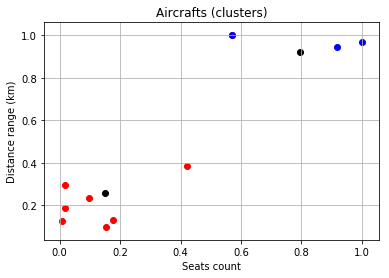

In [322]:
cluster()

red = X_norm[np.where(np.array(assignation)[:,0] > 0.5)]

blue = X_norm[np.where(np.array(assignation)[:,1] > 0.5)]

fig, ax = plt.subplots()

ax.scatter(blue[:,0],blue[:,1],c='red')

ax.scatter(red[:,0],red[:,1],c='blue')

ax.scatter(np.array(centers)[:,0],np.array(centers)[:,1],c='black')

ax.set(xlabel='Seats count', ylabel='Distance range (km)',
       title='Aircrafts (clusters)')

ax.grid()

plt.show()

In conclusion, the alhorith managed to categorize given data set into two groups. One problematic point is (~0.6, 1.0), which sometimes gets assigned into red group, and other times gets assigned into the blue one. 